In [1]:
import requests
import json
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
from datetime import datetime

import geopandas as gpd

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

USER = os.environ["USER"]
PASSWORD = os.environ["PASSWORD"]
DOMAIN = os.getenv('DOMAIN')

In [3]:
url = "https://openapi.emtmadrid.es/v1/mobilitylabs/user/login/"

headers = {
    'email': USER + "@" + DOMAIN,
    'password': PASSWORD 
    }

response = requests.request("GET", url, headers=headers)
#print(response.text)

valid_token = json.loads(response.text)["data"][0]["accessToken"]

In [4]:
stations_url = "https://openapi.emtmadrid.es/v1/transport/bicimad/stations/"

headers = {
    'accesstoken': valid_token

    }

response = requests.request("GET", stations_url, headers=headers)

stations_json_raw = response.json()


In [5]:
df_raw = pd.DataFrame(stations_json_raw['data'])
df_raw['id_'] = df_raw.index

In [6]:
df_raw.head()

,id,name,light,number,address,activate,no_available,total_bases,dock_bikes,free_bases,reservations_count,geometry,id_
0,1,Puerta del Sol A,1,1a,Puerta del Sol nº 1,1,0,30,24,2,0,"{'type': 'Point', 'coordinates': [-3.7018341, ...",0
1,2,Puerta del Sol B,1,1b,Puerta del Sol nº 1,1,0,30,30,0,0,"{'type': 'Point', 'coordinates': [-3.701602938...",1
2,3,Miguel Moya,1,2,Calle Miguel Moya nº 1,1,0,24,18,4,0,"{'type': 'Point', 'coordinates': [-3.7058415, ...",2
3,4,Plaza Conde Suchil,2,3,Plaza del Conde Suchil nº 2-4,1,0,18,6,7,0,"{'type': 'Point', 'coordinates': [-3.7069171, ...",3
4,5,Malasaña,0,4,Calle Manuela Malasaña nº 5,1,0,24,4,15,1,"{'type': 'Point', 'coordinates': [-3.7025875, ...",4


In [7]:
df_raw["geometry"][0]

{'type': 'Point', 'coordinates': [-3.7018341, 40.4172137]}

In [8]:
df_geo = pd.DataFrame(df_raw["geometry"].values.tolist(), index=df_raw.index)
df_geo.head(2)

,type,coordinates
0,Point,"[-3.7018341, 40.4172137]"
1,Point,"[-3.701602938060457, 40.41731271011562]"


In [9]:
df_geo[['Latitude','Longitude']] = pd.DataFrame(df_geo.coordinates.tolist(), index= df_geo.index)
df_geo["id_"] = df_geo.index
df_geo.head(2)

,type,coordinates,Latitude,Longitude,id_
0,Point,"[-3.7018341, 40.4172137]",-3.701834,40.417214,0
1,Point,"[-3.701602938060457, 40.41731271011562]",-3.701603,40.417313,1


In [10]:
gdf = gpd.GeoDataFrame(df_raw, geometry=gpd.points_from_xy(df_geo.Longitude, df_geo.Latitude))
gdf.head(2)

,id,name,light,number,address,activate,no_available,total_bases,dock_bikes,free_bases,reservations_count,geometry,id_
0,1,Puerta del Sol A,1,1a,Puerta del Sol nº 1,1,0,30,24,2,0,POINT (40.41721 -3.70183),0
1,2,Puerta del Sol B,1,1b,Puerta del Sol nº 1,1,0,30,30,0,0,POINT (40.41731 -3.70160),1


In [11]:
import folium

In [13]:
geo = pd.merge(df_raw, df_geo, on='id_')

In [19]:
location = [40.41955949449261,-3.6888147164886242]
bicimad_Map = folium.Map(
                location = location, 
                zoom_start = 14)

latitudes = list(geo.Latitude)
longitudes = list(geo.Longitude)
labels = list(geo.name)
for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker(
      location = [lng, lat], 
      popup = label,
      icon = folium.Icon()
     ).add_to(bicimad_Map)
bicimad_Map

In [28]:
air_q_stations = pd.read_csv('../data/informacion_estaciones_red_calidad_aire.csv', error_bad_lines=False, sep = ';', encoding = "ISO-8859-1")
air_q_stations.head(2)

,CODIGO,CODIGO_CORTO,ESTACION,DIRECCION,LONGITUD_ETRS89,LATITUD_ETRS89,ALTITUD,COD_TIPO,NOM_TIPO,NO2,...,HC,COD_VIA,VIA_CLASE,VIA_PAR,VIA_NOMBRE,Fecha alta,COORDENADA_X_ETRS89,COORDENADA_Y_ETRS89,LONGITUD,LATITUD
0,28079004,4,Pza. de España,Plaza de España,"3°42'43.91""O","40°25'25.98""N",637,UT,Urbana tráfico,X,...,NaN,273600,PLAZA,DE,ESPAÑA,01/12/1998,"439579,3291","4475049,263",-3.712257,40.423882
1,28079008,8,Escuelas Aguirre,Entre C/ Alcalá y C/ O Donell,"3°40'56.22""O","40°25'17.63""N",672,UT,Urbana tráfico,X,...,X,18900,CALLE,DE,ALCALA,01/12/1998,"442117,2366","4474770,696",-3.682316,40.421553


In [32]:
location = [40.41955949449261,-3.6888147164886242]
air_Map = folium.Map(
                location = location, 
                zoom_start = 14)

latitudes = list(air_q_stations.LONGITUD)
longitudes = list(air_q_stations.LATITUD)
labels = list(air_q_stations.ESTACION)
for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker(
      location = [lng, lat], 
      popup = label,
      icon = folium.Icon()
     ).add_to(air_Map)
air_Map

In [33]:
#hacer geopoints y hacer listado de puntos a max 15 m de distancia

bici_points = gdf
air_points = gpd.GeoDataFrame(air_q_stations, geometry=gpd.points_from_xy(air_q_stations.LATITUD, air_q_stations.LONGITUD))

,id,name,light,number,address,activate,no_available,total_bases,dock_bikes,free_bases,reservations_count,geometry,id_
0,1,Puerta del Sol A,1,1a,Puerta del Sol nº 1,1,0,30,24,2,0,POINT (40.41721 -3.70183),0
1,2,Puerta del Sol B,1,1b,Puerta del Sol nº 1,1,0,30,30,0,0,POINT (40.41731 -3.70160),1


In [58]:
air_points.head(2)

,CODIGO,CODIGO_CORTO,ESTACION,DIRECCION,LONGITUD_ETRS89,LATITUD_ETRS89,ALTITUD,COD_TIPO,NOM_TIPO,NO2,...,COD_VIA,VIA_CLASE,VIA_PAR,VIA_NOMBRE,Fecha alta,COORDENADA_X_ETRS89,COORDENADA_Y_ETRS89,LONGITUD,LATITUD,geometry
0,28079004,4,Pza. de España,Plaza de España,"3°42'43.91""O","40°25'25.98""N",637,UT,Urbana tráfico,X,...,273600,PLAZA,DE,ESPAÑA,01/12/1998,"439579,3291","4475049,263",-3.712257,40.423882,POINT (40.42388 -3.71226)
1,28079008,8,Escuelas Aguirre,Entre C/ Alcalá y C/ O Donell,"3°40'56.22""O","40°25'17.63""N",672,UT,Urbana tráfico,X,...,18900,CALLE,DE,ALCALA,01/12/1998,"442117,2366","4474770,696",-3.682316,40.421553,POINT (40.42155 -3.68232)


In [53]:
#from geopy.distance import distance 

coor_bici_stations_closer = [bici_points[['name','geometry']] for i,a in zip(list(air_points['geometry']), list(bici_points['geometry'])) if i.distance(a) < 15] 

In [54]:
coor_bici_stations_closer

[                   name                   geometry
 0      Puerta del Sol A  POINT (40.41721 -3.70183)
 1      Puerta del Sol B  POINT (40.41731 -3.70160)
 2           Miguel Moya  POINT (40.42059 -3.70584)
 3    Plaza Conde Suchil  POINT (40.43029 -3.70692)
 4              Malasaña  POINT (40.42855 -3.70259)
 ..                  ...                        ...
 237     Embajadores 191  POINT (40.38926 -3.69036)
 238      Paseo Imperial  POINT (40.40765 -3.71722)
 239      Pablo Iglesias  POINT (40.45133 -3.71053)
 240          San Germán  POINT (40.45619 -3.69294)
 241   Francos Rodríguez  POINT (40.45673 -3.70800)
 
 [242 rows x 2 columns],
                    name                   geometry
 0      Puerta del Sol A  POINT (40.41721 -3.70183)
 1      Puerta del Sol B  POINT (40.41731 -3.70160)
 2           Miguel Moya  POINT (40.42059 -3.70584)
 3    Plaza Conde Suchil  POINT (40.43029 -3.70692)
 4              Malasaña  POINT (40.42855 -3.70259)
 ..                  ...             

In [55]:
from shapely.ops import nearest_points

In [68]:
nearest_points(bici_points["geometry"][0], pts3)


(<shapely.geometry.point.Point at 0x7fd9b9ace690>,
 <shapely.geometry.point.Point at 0x7fd9b9acea10>)

In [74]:
pts3 = air_points.geometry.unary_union
def near(point, pts=pts3):
     # find the nearest point and return the corresponding Place value
    nearest = air_points.geometry == nearest_points(point, pts)[1]
    return air_points.CODIGO[0]

bici_points['CODIGO'] = bici_points["geometry"].apply(lambda x: near(x))
bici_points.head()

,id,name,light,number,address,activate,no_available,total_bases,dock_bikes,free_bases,reservations_count,geometry,id_,distance_to_air,Nearest,CODIGO
0,1,Puerta del Sol A,1,1a,Puerta del Sol nº 1,1,0,30,24,2,0,POINT (40.41721 -3.70183),0,0.012373,28079004,28079004
1,2,Puerta del Sol B,1,1b,Puerta del Sol nº 1,1,0,30,30,0,0,POINT (40.41731 -3.70160),1,0.019748,28079004,28079004
2,3,Miguel Moya,1,2,Calle Miguel Moya nº 1,1,0,24,18,4,0,POINT (40.42059 -3.70584),2,0.042020,28079004,28079004
3,4,Plaza Conde Suchil,2,3,Plaza del Conde Suchil nº 2-4,1,0,18,6,7,0,POINT (40.43029 -3.70692),3,0.068374,28079004,28079004
4,5,Malasaña,0,4,Calle Manuela Malasaña nº 5,1,0,24,4,15,1,POINT (40.42855 -3.70259),4,0.082109,28079004,28079004


In [72]:
df = pd.merge(bici_points, air_points, on='CODIGO', how = 'left')

In [76]:
df_aux = df[['id','name', 'geometry_x', "CODIGO", "ESTACION", "geometry_y"]]
df_aux.head()

,id,name,geometry_x,CODIGO,ESTACION,geometry_y
0,1,Puerta del Sol A,POINT (40.41721 -3.70183),28079004,Pza. de España,POINT (40.42388 -3.71226)
1,2,Puerta del Sol B,POINT (40.41731 -3.70160),28079004,Pza. de España,POINT (40.42388 -3.71226)
2,3,Miguel Moya,POINT (40.42059 -3.70584),28079004,Pza. de España,POINT (40.42388 -3.71226)
3,4,Plaza Conde Suchil,POINT (40.43029 -3.70692),28079004,Pza. de España,POINT (40.42388 -3.71226)
4,5,Malasaña,POINT (40.42855 -3.70259),28079004,Pza. de España,POINT (40.42388 -3.71226)


In [86]:
def getXY(pt):
    return (pt.x, pt.y)

centroidseries = df_aux['geometry_x'].apply(lambda x: x.centroid)
df_aux['bici_lon'],df_aux['bici_lat'] = [list(t) for t in zip(*map(getXY, centroidseries))]

centroidseries = df_aux['geometry_y'].apply(lambda x: x.centroid)
df_aux['air_lon'],df_aux['air_lat'] = [list(t) for t in zip(*map(getXY, centroidseries))]

/home/fserrey/anaconda3/envs/jupyter_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/fserrey/anaconda3/envs/jupyter_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [88]:
location = [40.41955949449261,-3.6888147164886242]
mapa = folium.Map(
                location = location, 
                zoom_start = 14)

lon_bici = list(df_aux.bici_lon)
lat_bici = list(df_aux.bici_lat)
lon_air = list(df_aux.air_lon)
lat_air = list(df_aux.air_lat)

bici_stations_tag = list(df_aux.name)
air_stations_tag = list(df_aux.ESTACION)

for lat, lng, label in zip(lon_bici, lat_bici, bici_stations_tag):
    folium.Marker(
          location = [lat, lng], 
          popup = bici_stations_tag,
          icon = folium.Icon(color='blue')
         ).add_to(mapa) 
    
for lat, lng, label in zip(lon_air, lat_air, air_stations_tag):        
    folium.Marker(
          location = [lat, lng], 
          popup = air_stations_tag,
          icon = folium.Icon(color='green')
         ).add_to(mapa)
mapa

In [78]:
import geopandas as gpd
from shapely.geometry import Polygon

lat_point_list = [50.854457, 48.853033, 52.518172, 50.072651, 50.854457]
lon_point_list = [4.377184, 2.349553, 13.407759, 14.435935, 4.377184]

polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon_geom2 = polygon_geom.convex_hull # the atribute
import folium
m = folium.Map([50.854457, 4.377184], zoom_start=5, tiles='cartodbpositron')
folium.GeoJson(polygon_geom).add_to(m)
folium.GeoJson(polygon_geom2).add_to(m)
folium.LatLngPopup().add_to(m)
m

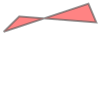

In [80]:
polygon_geom